In [131]:
# Data-driven Newsvendor with Pricing
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline

In [132]:
#Initalization
a = 0 #y-intercept or market size
b = 0 #coefficient of price
p = [] #price sampling
D = [] #demand sampling
u = [] #estimation error term sampling
sigma = 0 #std of estimation error terms sampling


In [133]:
#Parameters for example illustration
n = 200 #sample size
cv = 0.5 #coefficient of variance
c = 0.5 #procurement cost per unit
alpha = 0.9 #non-stockout probability

#Sampling range
lbp = 1 #lower bound of price
ubp = 1.5 #upper bound of price
lba = 1500 #lb of a
uba = 2000 #up of a
lbb = 500 #lb of b
ubb = 1000 #ub of b

# IMPLEMENTATION

We can divide the main problem into two subproblems as follows:  
1) to learn the relationship between demand/ ordering quantity and price   
2) to find optimal quantity and price   


## DEMAND/ ORDERING QUANTITY ESTIMATION (BEUTEL 2012)

**Reference:** Beutel, A. L., & Minner, S. (2012). *Safety stock planning under causal demand forecasting*. International Journal of Production Economics, 140(2), 637-645.

### Function to generate sampling of demand and price:
Demand is presented here as a function of price p: D(p) = a - b\*p + u.  
Demand - price observation set is built by randomly choose a, b, p and u. In more detail:
- market size a ~ U(1500, 2000)
- slope b ~ U(500, 1000)
- uniformly chosen sample of price p (with size = sampleSize) in range [1, 1.5] 
- D equals to the sum of prediction value plus estimation error u ~ N(0, sigma). Sigma is chosen so that the coefficient of variation at mean price p equals coefVar.

It should be noticed that here we will focus on the case that demand is relatively elastic with price. The reason is that in case of relatively price elasticity, demand responds weakly with the changes of price. Therefore, the vendor has the incentive to increase price as much as possible while only facing a little decrease in demand quantity. Combining with a ratio between overage and underage cost that is low enough (co < cu), it may lead to an ordering quantity function increasing with price increase and an unbound problem in price-setting newsvendor problem. Therefore, in the sampling generation function, we will reject the sample with relatively low price elasticity (<1) by checking the arc elasticity over the defined price range from OLS linear regression demand function.


In [134]:
# Demand - Price generation
def samplingDemand(sampleSize, coefVar):
    
    global a, b, p, D, u, sigma
    a = 0; b = 0; p = []; D = []; u = []; sigma = 0;
    
    lowElasticity = True
    while lowElasticity:
        a = np.random.uniform(low = lba, high = uba)
        b = np.random.uniform(low = lbb, high = ubb)
        p = np.random.uniform(size = [sampleSize, 1])*(ubp - lbp) + lbp # uniformly chosen in price range [1, 1.5]

        meanP = np.mean(p)
        sigma = (a - b*meanP)*coefVar
        u = np.zeros(shape = (sampleSize,))
        D = np.repeat(-1, repeats = sampleSize)
        for i in range(sampleSize):
            while D[i] < 0:
                u[i] = np.random.normal(loc = 0, scale = sigma)
                D[i] = a - b*p[i] + u[i]
 

        #check Arc price elasticity
        # OLS Linear regression for comparison
        reg = linear_model.LinearRegression().fit(p, D)
        coef2 = reg.coef_
        coef1 = reg.intercept_
        Q1 = coef1 + coef2*lbp
        Q2 = coef1 + coef2*ubp
        arcElasticity = ((lbp + ubp) / (Q1 + Q2)) * ((Q2 - Q1) / (ubp - lbp))
        if abs(arcElasticity) >= 1: lowElasticity = False
    
    return coef1, coef2

Sampling example:

Text(0.5, 1.0, 'Demand sampling')

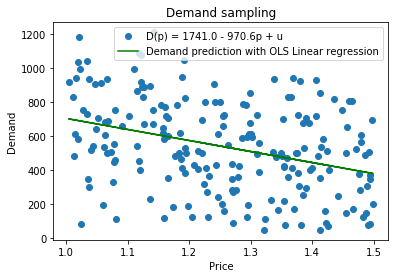

In [135]:
coef1, coef2 = samplingDemand(sampleSize = n, coefVar = cv)
plt.plot(p,D, 'o', label = 'D(p) = ' + str(round(a,0)) + ' - ' + str(round(b,2)) + 'p + u')
plt.plot(p, coef1 + coef2*p, 'g-', label = 'Demand prediction with OLS Linear regression')
plt.legend(loc = 8)
plt.xlabel('Price')
plt.ylabel('Demand')
plt.legend()
plt.title('Demand sampling')

### Optimization model to find the ordering quantity as a function of price
Here we use the approach presented in Beutel (2012) that integrates demand estimation and ordering optimization in a single model (instead of sequential steps) to learn about the relationship between ordering quantity and price. The main idea is to predict the ordering quantity by exploring historical data of demand-price with consideration of the overage and underage costs during estimating (i.e. different weights applied to the positive/negative errors in regression).  
  
There is a slight difference in two models below to the base models in Beutel (2012). In her models, Beutel assumes fixed holding cost and penalty cost, representing the overage and underage cost respectively. In other words, these costs are **independent with selling price**. However, here we will define the overage and underage cost as in the traditional newsvendor model, i.e.:     
- overage cost (co) = procurement cost (c)
- underage cost (cu) = selling price - procurement cost (p-c)

Therefore, the underage cost and so the critical fractile **depends on the selling price**. This modification is to match with the model in the second step and is more logical especially when considering the context of price-setting newsvendor, since it causes the trade-off characteristic in price decision. For example, increasing price affects the total cost (expected profit) in both positive way by decreasing underage cost (increasing revenue) per unit and negative way by decreasing demand.


Two following models assume ordering quantity is a linear function of the price: *q = beta0 + beta1 * p*. The decision variables in these models are the coefficients beta0 and beta1, as well as the waste (overage) and shortage (underage) for each demand observation. The objective function is considered as a cost minimization objective or with a service level constraint in each model.

#### The cost model

In [136]:
# Cost model
def costModel(sampleSize, procurementCost):
    
    baseCostModel = gp.Model("Base Cost model")

    #### Variables
    betaC0 = baseCostModel.addVar(lb = - GRB.INFINITY, vtype = GRB.CONTINUOUS) # ~ a
    betaC1 = baseCostModel.addVar(lb = - GRB.INFINITY, vtype = GRB.CONTINUOUS) # ~ b

    waste = {} # = q - D (overage)
    shortage = {} # = D - q (underage)
    sales = {} # = min(D, q)
    for i in range(sampleSize):
        #overage cost per unit = c(co)
        waste[i] = baseCostModel.addVar(lb = 0, vtype = GRB.CONTINUOUS, obj = procurementCost) 
        #underage cost per unit = p-c (cu)
        shortage[i] = baseCostModel.addVar(lb = 0, vtype = GRB.CONTINUOUS, obj = p[i] - procurementCost)

        sales[i] = baseCostModel.addVar(lb = 0, vtype = GRB.CONTINUOUS)

    #### Constraints
    for i in range(sampleSize):
        baseCostModel.addConstr(shortage[i] == D[i] - sales[i])
        baseCostModel.addConstr(waste[i] >= betaC0 + betaC1 * p[i] - D[i])
        baseCostModel.addConstr(sales[i] <= D[i])
        baseCostModel.addConstr(sales[i] <= betaC0 + betaC1 * p[i])
        
    baseCostModel.Params.OutputFlag = 0
    baseCostModel.optimize()
    obj = baseCostModel.objVal; beta0 = betaC0.x; beta1 = betaC1.x;
    baseCostModel.dispose()
    
    return obj, beta0, beta1

Example of ordering quantity function with Cost model

Objective: 24860.180747037786
Estimation of a: 1161.4400969210872
Estimation of b: -442.82905437319835

Ordering quantity - price function: D =  1161.0 + -442.83 * p


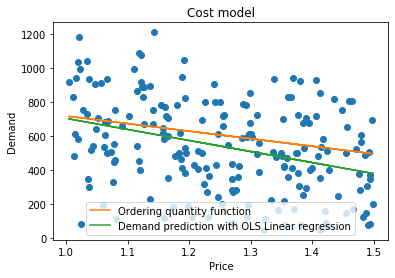

In [137]:
objC, betaC0, betaC1 = costModel(sampleSize = n, procurementCost = c)
print("Objective:",objC)
print('Estimation of a:', betaC0)
print('Estimation of b:', betaC1)

print('\nOrdering quantity - price function: D = ', round(betaC0,0),'+', round(betaC1,2),'* p')


#Plot
plt.plot(p,D,'o')
plt.plot(p, betaC0 + betaC1*p, label='Ordering quantity function')
plt.plot(p, coef1 + coef2*p, label = 'Demand prediction with OLS Linear regression')
plt.legend(loc = 8)
plt.xlabel('Price')
plt.ylabel('Demand')
plt.title('Cost model')
plt.show()

#### The service level model

In [38]:
# Service level model
def SLModel(sampleSize, procurementCost, nonStockOut):
    
    baseSLModel = gp.Model("Base Service level model")

    #### Variables
    betaSL0 = baseSLModel.addVar(lb = - GRB.INFINITY, vtype = GRB.CONTINUOUS) # ~ a
    betaSL1 = baseSLModel.addVar(lb = - GRB.INFINITY, vtype = GRB.CONTINUOUS) # ~ b

    waste = {}
    sales = {}
    unfulfilled = {} # binary variable = 1 if D > q (underage, unfulfilled demand existing), = 0 otherwise
    for i in range(sampleSize):
        waste[i] = baseSLModel.addVar(lb = 0, vtype = GRB.CONTINUOUS, obj = procurementCost)   
        sales[i] = baseSLModel.addVar(lb = 0, vtype = GRB.CONTINUOUS)
        unfulfilled[i] = baseSLModel.addVar(vtype = GRB.BINARY)

    #### Constraints
    for i in range(sampleSize):
        baseSLModel.addConstr(waste[i] >= betaSL0 + betaSL1 * p[i] - D[i])
        baseSLModel.addConstr(sales[i] <= D[i])
        baseSLModel.addConstr(sales[i] <= betaSL0 + betaSL1 * p[i])

        #if D < q then unfulfilled must equal to 1
        baseSLModel.addConstr(D[i] - unfulfilled[i]*np.max(D) <= betaSL0 + betaSL1 * p[i])

    #non-stockout (alpha level)    
    baseSLModel.addConstr(sum(unfulfilled[i] for i in range(sampleSize)) <= sampleSize*(1-nonStockOut)) 

    #fillrate (beta level)
    #baseSLModel.addConstr( sum(sales[i] for i in range(sampleSize)) >= fillRate * sum(D[i] for i in range(sampleSize)) )

    baseSLModel.Params.OutputFlag = 0
    baseSLModel.optimize()
    obj = baseSLModel.objVal; beta0 = betaSL0.x; beta1 = betaSL1.x;
    baseSLModel.dispose()
    
    return obj, beta0, beta1

Example of ordering quantity function with Service level model (alpha level)

Objective: 37480.86121921657
Estimation of a: 1957.1556277461339
Estimation of b: -804.3990742588601

Ordering quantity - price function: D =  1957.0 + -804.4 * p


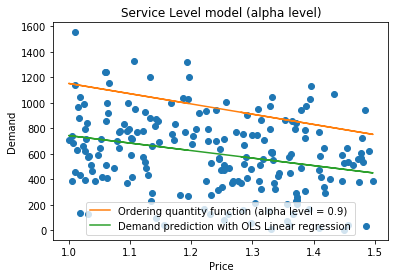

In [39]:
objSL, betaSL0, betaSL1 = SLModel(sampleSize = n, procurementCost = c, nonStockOut = alpha)
print("Objective:",objSL)
print('Estimation of a:', betaSL0)
print('Estimation of b:', betaSL1)

print('\nOrdering quantity - price function: D = ', round(betaSL0,0),'+', round(betaSL1,2),'* p')


# OLS Linear regression for comparison
reg = linear_model.LinearRegression().fit(p, D)
coef2 = reg.coef_
coef1 = reg.intercept_

#Plot
plt.plot(p,D,'o')
plt.plot(p, betaSL0 + betaSL1*p, label='Ordering quantity function (alpha level = ' +str(alpha)+')' )
plt.plot(p, coef1 + coef2*p, label = 'Demand prediction with OLS Linear regression')
plt.legend(loc = 8)
plt.xlabel('Price')
plt.ylabel('Demand')
plt.title('Service Level model (alpha level)')
plt.show()

## PRICE AND QUANTITY-SETTING NEWSVENDOR

**Reference:**   
Kyparisis, G.J. & Koulamas, C. (2018). *The price-setting newsvendor problem with nonnegative linear additive demand.* European Journal of Operational Research, 269(2), 695-698.   
DeYong, G. D. (2020). *The price-setting newsvendor: review and extensions.* International Journal of Production Research, 58(6), 1776-1804.
Huber et. al. (2019). *A data-driven newsvendor problem: From data to decision.* European Journal of Operational Research, 278(3), 904-915.

 ### Basic approach

From the previous model, we obtain the ordering quantity function of price: *q = beta0 + beta1 * p*. It means that at a certain selling price p, we can calculate a corresponding ordering quantity q, which also represents the estimated demand level at that selling price. So if the relationship between demand and price is captured completely, the expected profit is:  
$\Pi(p)  = p*q(p) - c*q(p) = beta1*p^2 + (beta0 - beta1*c)*p - beta0*c$  
By taking the first-order derivative, we can find the optimal price p* as $\frac{1}{2*beta1}(-beta0 + beta1*c) $   (1)  and so, the optimal ordering quantity q*.   

Below is the optimization model of this approach (hereinafter called as "Basic approach"). The optimal price from this model is similar to the one calculated from equation (1).

To make the problem logical, the lower bound of price is procurement cost per unit (p >= c) and the upper bound is -beta0/beta1 so that the expected demand is non-negative. Additionally, beta1 must be lessthan or equal to 0 so the profit function is concave and the problem is bounded. Otherwise, the problem is unbounded and we will choose the price as high as possible (i.e. maximum value of price in historical data).   

In [10]:
#Price-setting 
def NV_Price(procurementCost, beta0, beta1):
    if beta1 > 0: 
        return ubp * (beta0 + beta1*ubp) - procurementCost*(beta0 + beta1*ubp), ubp, (beta0 + beta1*ubp)
    else:
        pricingNV = gp.Model("Pricing NV model")

        #### Variables
        price = pricingNV.addVar(lb = procurementCost, ub = -beta0/beta1, vtype = GRB.CONTINUOUS)
        quantity = pricingNV.addVar()

        pricingNV.addConstr(quantity == beta0 + beta1*price)

        pricingNV.setObjective( price * quantity - procurementCost*quantity) #maximize expected profit
        pricingNV.modelSense = 0 #maximization

        pricingNV.Params.OutputFlag = 0
        pricingNV.Params.NonConvex = 2 #enable Quadratic Optimization mode of Gurobi
        pricingNV.optimize()

        return pricingNV.objVal, price.x, quantity.x

Example with results from Cost model:

In [11]:
objVal, price, quantity = NV_Price(procurementCost = c, beta0 = betaC0, beta1 = betaC1)

print('\n\n')
print('Optimal price from LP model:', price)
print('Optimal price from equation (1):', 0.5*(-betaC0+betaC1*c)/betaC1)




Optimal price from LP model: 1.3874078464837634
Optimal price from equation (1): 1.3874078464837634


### Data-driven approach

However, another approach is proposed here to make the solution more data-driven and robust. Using error terms obtained from historical data, we can generate the distribution of estimated demand at a certain price and then solve a data-driven quantity-setting newsvendor problem with this given price. In detail, demands at certain price p have the form of d(p) = beta0 + beta1 * p + u, with E[d(p)] = beta0 + beta1 * p, which is the estimated demand level from the previous model. u are error terms of all observations, which are independent with prices according to previously-mentioned assumptions.


In [12]:
#Newsvendor with Price-setting
def DDNV_Price(sampleSize, procurementCost, beta0, beta1):
    if beta1 > 0: 
        return ubp * (beta0 + beta1*ubp) - procurementCost*(beta0 + beta1*ubp), ubp, (beta0 + beta1*ubp)
    else:
        M = beta0*2

        pricingNV = gp.Model("Pricing NV model")

        #### Variables
         #same price range to avoid extrapolation ?
        price = pricingNV.addVar(lb = procurementCost, ub = -beta0/beta1, vtype = GRB.CONTINUOUS)
        quantity = pricingNV.addVar()

        sales = {}
        z = {} #binary variable = 1 if D = a - bp + u > 0, =0 otherwise ==> to ensure demand not negative: D = max(0, a-bp+u)

        for t in range(sampleSize):
            sales[t] = pricingNV.addVar()
            z[t] = pricingNV.addVar(vtype = GRB.BINARY)

        for t in range(sampleSize):
            pricingNV.addConstr(M*z[t] >= beta0 + beta1*price + u[t] ) #if a-bp+u > 0, z must equal to 1
            pricingNV.addConstr(sales[t] <= 0 + M*z[t] )
            pricingNV.addConstr(sales[t] <= beta0 + beta1*price + u[t] + M*(1-z[t]) )
            pricingNV.addConstr(sales[t] <= quantity)

        pricingNV.setObjective( price * sum(sales[t] for t in range(sampleSize)) / sampleSize - procurementCost*quantity) #maximize expected profit
        pricingNV.modelSense = 0 #maximization

        pricingNV.Params.OutputFlag = 0

        pricingNV.Params.NonConvex = 2 #enable Quadratic Optimization mode of Gurobi
        pricingNV.optimize()


        return pricingNV.objVal, price.x, quantity.x

Example run with results from Cost model

In [13]:
objValDD, priceDD, quantityDD = DDNV_Price(sampleSize = n, procurementCost = c, beta0 = betaC0, beta1 = betaC1)

print("Objective: ", objValDD)
print('Optimal price:', priceDD)
print('Optima ordering quantity:', quantityDD)

Objective:  443.2349005735817
Optimal price: 1.3508230281754816
Optima ordering quantity: 800.6586784714189


In [14]:
# method to combine two steps

In [15]:
def DDNV_main(sampleSize, procurementCost, estimationModel = 'cost', nonStockOut = None):

    if estimationModel == 'service' and nonStockOut is not None:
        (estObjVal, estBeta0, estBeta1) = SLModel(sampleSize, procurementCost)
    else:                
        (estObjVal, estBeta0, estBeta1) = costModel(sampleSize, procurementCost)
    print('\nOrdering quantity parameters:', estBeta0, estBeta1)

    (optV, optP, optQ) = NV_Price(procurementCost, estBeta0, estBeta1)
    print('Basic approach:', optV, optP, optQ)

    (optVDD, optPDD, optQDD) = DDNV_Price(sampleSize, procurementCost, estBeta0, estBeta1)
    print('Data-driven approach:', optVDD, optPDD, optQDD,'\n')

        
    return optV, optP, optQ, optVDD, optPDD, optQDD


In [16]:
DDNV_main(sampleSize = n, procurementCost = c, estimationModel = 'cost', nonStockOut = None)


Ordering quantity parameters: 1678.0171183797343 -737.6497021570741
Basic approach: 580.8937452794755 1.3874078464837634 654.5961336505986
Data-driven approach: 443.2349005735817 1.3508230281754816 800.6586784714189 



(580.8937452794755,
 1.3874078464837634,
 654.5961336505986,
 443.2349005735817,
 1.3508230281754816,
 800.6586784714189)

# ANALYSIS

## Sensitivity analysis

### 1. Procurement cost's effect       

Here we want to learn about the influence of procurement cost (c) on the optimal price and ordering quantity. To do so, for a certain sampling set, we run the model with different procurement costs from 0.1 to 0.9 (since c < p). Then this test is done for multiple times to get the average optimal price and ordering quantity over all test instances.

In [17]:
testRep = 50
costSet = [0.1*(i+1) for i in range(9)]
resultCost = pd.DataFrame(index = range(len(costSet)), columns = ['Procurement cost', 'Avg. opt. price (Basic)', 'Avg. opt. order qty (Basic)', 'Avg. opt. price (DD)', 'Avg. opt. order qty (DD)' ])

optPrice = np.zeros(shape=(len(costSet),testRep))
optQty = np.zeros(shape=(len(costSet),testRep))
optPriceDD = np.zeros(shape=(len(costSet),testRep))
optQtyDD = np.zeros(shape=(len(costSet),testRep))
for j in range(testRep):
    print('Test run = ', j)
    samplingDemand(sampleSize=n, coefVar=cv)
    
    for i in range(len(costSet)):
        print('Considering c =', costSet[i])
        optV, optP, optQ, optVDD, optPDD, optQDD = DDNV_main(sampleSize=n, procurementCost=costSet[i], estimationModel = 'cost', nonStockOut = None)
        
        optPrice[i,j] = optP
        optQty[i,j] = optQ
        optPriceDD[i,j] = optPDD
        optQtyDD[i,j] = optQDD    

for i in range(len(costSet)):
    resultCost.iloc[i,:] = [costSet[i], np.mean(optPrice[i,:]), np.mean(optQty[i,:]), 
                            np.mean(optPriceDD[i,:]), np.mean(optQtyDD[i,:])]

Test run =  0
Considering c = 0.1

Ordering quantity parameters: 1492.8706157779088 -758.3637595433987
Basic approach: 661.9468597897344 1.0342708047367317 708.5171199117846
Data-driven approach: 656.5181526170027 1.0440367537108615 910.5541448518204 

Considering c = 0.2

Ordering quantity parameters: 1476.0560964603649 -795.248354135866
Basic approach: 545.2717745778509 1.0280472501350093 658.5032128165958


KeyboardInterrupt: 

In [ ]:
resultCost

**Comment:** In general, when the procurement cost increases, the optimal price also increases to cover up the increase in cost, leading to the decrease in optimal ordering quantity. We can see that in general, the increase speed in optimal price in Data-driven approach is slower than that of Basic approach. It is because in Basic approach, the optimal price is calculated from a fixed equation so the change in cost is shown completely; meanwhile, in Data-driven approach, this influence is affected by the stochastic demand.

To generate out-of-sample demand observations, we will randomly draw 100,000 error terms in the same way as we dis previously with sampling set (u ~ N(0,sigma)) and D = a - b * p + u, with . This out-of-sample set will be used to evaluate the performance of the solution, which will be done for a significant number of times to obtain the average performance.

In [ ]:
def outOfSampleError(testSize):
    testU = np.random.normal(loc = 0, scale = sigma, size =(testSize,) )
    return testU

In [ ]:
def outOfSampleDemand(testU, chosenPrice):
    testD = a - b*chosenPrice + testU
    for i in range(len(testD)):
        if testD[i]<=0: testD[i] = 0
            
    return testD

In [ ]:
def testEvaluation(testD, chosenPrice, chosenQty, procurementCost):
    return sum( [chosenPrice * min(testD[i], chosenQty) for i in range(len(testD))] ) / len(testD) - procurementCost*chosenQty   
    

### 2. Sample size's effect       

Here we want to learn about the effect of sample size on performance of solution. To do so, from the same demand sampling set, we take subsets with different sizes and solve the problem with these subsets. The solutions are evaluated by generating out-of-sample demand based on each chosen price solution with same error terms. Then this test is done for multiple times to get the average objective value (i.e. expected profit).

In [ ]:
import copy

testRep = 50

# Run the model with different sample sizes: 50, 100, 200, 500 and 700
sampleSizeSet = [50, 100, 200, 500, 700]
resultSize = pd.DataFrame(index = range(len(sampleSizeSet)), columns = ['Sample size','Avg. in-sample profit', 'Avg. out-of-sample profit'])
optValInSample = np.zeros(shape=(len(sampleSizeSet),testRep))
optValOutSample = np.zeros(shape=(len(sampleSizeSet),testRep))
for j in range(testRep):
    print('Test run = ', j)
    samplingDemand(sampleSize=max(sampleSizeSet), coefVar=cv)
    demandPool = copy.deepcopy(D)
    pricePool = copy.deepcopy(p)
    errorPool = copy.deepcopy(u)
    
    testU = outOfSampleError(testSize = 100000)
    
    for i in range(len(sampleSizeSet)):
        print('Considering n =', sampleSizeSet[i])
        if sampleSizeSet[i] != max(sampleSizeSet):
            lowElasticity = True
            while lowElasticity:
                idx = np.random.choice(max(sampleSizeSet), size = sampleSizeSet[i], replace = False)
                for k in range(len(idx)): 
                    D[k] = demandPool[k] 
                    p[k] = pricePool[k] 
                    u[k] = errorPool[k]
                
                reg = linear_model.LinearRegression().fit(p, D)
                coef2 = reg.coef_
                coef1 = reg.intercept_
                Q1 = coef1 + coef2*min(p)
                Q2 = coef1 + coef2*max(p)
                arcElasticity = ( (min(p) + max(p)) / (Q1 + Q2)) * ((Q2 - Q1) / (max(p) - min(p)) )
                if abs(arcElasticity) >= 1: lowElasticity = False

        else:
            D = demandPool; p = pricePool; u = errorPool;
        
        optV, optP, optQ, optVDD, optPDD, optQDD = DDNV_main(sampleSize=sampleSizeSet[i], procurementCost=c, estimationModel = 'cost', nonStockOut = None)
        
        testD = outOfSampleDemand(testU, chosenPrice = optPDD)
        testV = testEvaluation(testD, chosenPrice = optPDD, chosenQty = optQDD, procurementCost = c)
        
        optValInSample[i,j] = optVDD
        optValOutSample[i,j] = testV
        
for i in range(len(sampleSizeSet)):
    resultSize.iloc[i,:] = [sampleSizeSet[i], np.mean(optValInSample[i,:]), np.mean(optValOutSample[i,:])]

In [ ]:
resultSize

**Comment:** As expected, the more historical data we have, the higher the out-of-sample profit is, which means better solution we have. With more data, the relationship between demand and price is capture more correctly and so the estimated demand is nearer to the true demand. 

## Basic approach vs Data-driven approach in Price and Quantity-setting Newsvendor

Here we want to compare the performance of Basic approach with Data-driven approach to solve the Price and Quantity-setting Newsvendor. In basic approach, the vendor takes the optimal price as given from the ordering quantity function, while in Data-driven approach, the vendor use the historical data to make the solution more robust.

For a certain sampling set, we runs both approaches to obtain the solution of optimal price and ordering quantity. Two solutions are evaluated with the same out-of-sample demand set to get the profit of each solution when dealing with unknown demand. Then this test is done for multiple times to get the average performance of each solution.

In [ ]:
testRep = 200

resultDD = pd.DataFrame(index = range(testRep), columns = ['Out-of-sample profit (Basic)', 'Out-of-sample profit (Data-driven)'])

for j in range(testRep):
    print('Test run = ', j)
    samplingDemand(sampleSize=n, coefVar=cv)
    testU = outOfSampleError(testSize = 100000)
    
    optV, optP, optQ, optVDD, optPDD, optQDD = DDNV_main(sampleSize=n, procurementCost=c, estimationModel = 'cost', nonStockOut = None)

    #Basic approach
    testD = outOfSampleDemand(testU, chosenPrice = optP)
    testV = testEvaluation(testD, chosenPrice = optP, chosenQty = optQ, procurementCost = c)
    
    #Data-driven approach
    testDDD = outOfSampleDemand(testU, chosenPrice = optPDD)
    testVDD = testEvaluation(testDDD, chosenPrice = optPDD, chosenQty = optQDD, procurementCost = c)
    
    resultDD.iloc[j,:] = [testV, testVDD]
    
print(resultDD)
print('\n\nThe average out-of-sample profit from Basic approach:', np.mean(resultDD.iloc[:,0]) )
print('The average out-of-sample profit from Data-driven approach:', np.mean(resultDD.iloc[:,1]) )

Data source: https://www.dunnhumby.com/careers/engineering/sourcefiles  
Breakfast at the Frat contains sales and promotion information on the top five products from each of the top three brands within four selected categories (mouthwash, pretzels, frozen pizza, and boxed cereal), gathered from a sample of stores over 156 weeks.

In [ ]:
data = pd.read_excel('dunnhumby - Breakfast at the Frat.xlsx', sheet_name = 'dh Transaction Data', skiprows = range(1), header = 0)

In [ ]:
stores = data.loc[((data['STORE_NUM'] == 15547) | (data['STORE_NUM'] == 21213) | (data['STORE_NUM'] == 26981)), ['WEEK_END_DATE', 'UPC', 'UNITS', 'PRICE', 'BASE_PRICE']]

In [ ]:
stores

To evaluate the performance of our approach, we will choose one product with high variance in demand and one product with low variance to implement our method. 

In [ ]:
highVar = data.loc[((data['UPC'] == 3000006610) & ((data['STORE_NUM'] == 15547) | (data['STORE_NUM'] == 21213) | (data['STORE_NUM'] == 26981))), ['WEEK_END_DATE', 'UNITS', 'PRICE', 'BASE_PRICE']]
midVar = data.loc[((data['UPC'] == 7192100339) & ((data['STORE_NUM'] == 15547) | (data['STORE_NUM'] == 21213) | (data['STORE_NUM'] == 26981))), ['WEEK_END_DATE', 'UNITS', 'PRICE', 'BASE_PRICE']]
lowVar = data.loc[((data['UPC'] == 1111009477) & ((data['STORE_NUM'] == 15547) | (data['STORE_NUM'] == 21213) | (data['STORE_NUM'] == 26981))), ['WEEK_END_DATE', 'UNITS', 'PRICE', 'BASE_PRICE']]

In [ ]:
plt.plot(lowVar.PRICE, lowVar.UNITS, 'bo')
plt.plot(lp, coef1 + coef2*lp, 'g-')

For each product, we assume that the cost per unit equal to 30% of the average base price.
We set the train set (historical data) as demands 

In [ ]:
plt.plot(midVar.PRICE, midVar.UNITS, 'bo')


In [ ]:
lp = np.array(lowVar['PRICE'])
lp = lp.reshape(-1, 1)
lu = list(lowVar['UNITS'])
reg = linear_model.LinearRegression().fit(lp,lu)
coef2 = reg.coef_
coef1 = reg.intercept_
print(coef1, coef2)

